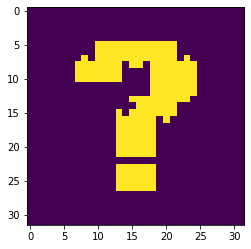

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

'''
First load in the substrate and visualise it
'''

substrate = np.load('data/toy_examples/question_mark_substrate.npy')

plt.imshow(substrate)

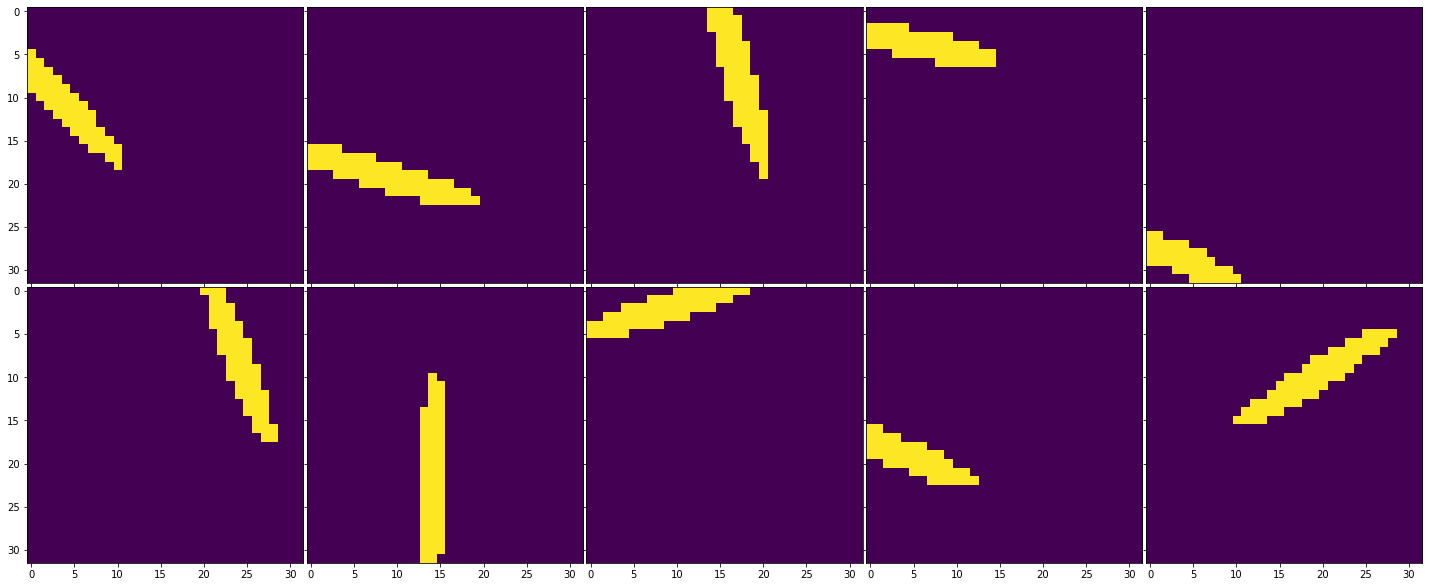

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid

'''
Load in 1000 32x32 lesions, that are basically just ellipsoids
'''

lesions = np.load('data/toy_examples/1000_lesions.npy')

# Let's visualise a few
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 5),
                 axes_pad=0.05,
                 share_all=True
                 )

for i in range(10):
    grid[i].imshow(lesions[i])

(array([606.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 394.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

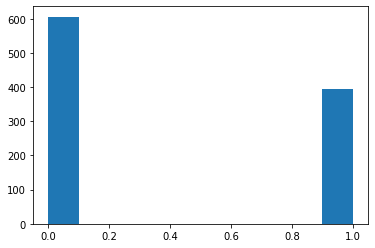

In [3]:
# LET'S SIMULATE SOME BINARY SCORES

# Threshold after which there is deficit
BINARY_THRESHOLD = 0.05

deficit_scores = [0 for i in range(len(lesions))]
positive_indices = []
for i in range(len(lesions)):
    overlap = lesions[i] * substrate
    counts = np.count_nonzero(overlap)
    voxels_gt = np.sum(substrate)
    ratio_lesion = counts / voxels_gt

    if ratio_lesion > BINARY_THRESHOLD:
        deficit_scores[i] = 1 
    else:
        deficit_scores[i] = 0
                
deficit_scores = np.array(deficit_scores)
plt.hist(deficit_scores)

In [4]:
from sklearn.model_selection import train_test_split

# WE NEED TO ADD ONE EXTRA CHANNEL AS DL MODELS EXPECT A COLOUR CHANNEL
lesions = np.expand_dims(lesions, axis=1)

# FIRST SPLIT INTO 90/10
train_data, vc_data, train_labels, vc_labels = train_test_split(lesions,
                                                                deficit_scores,
                                                                test_size=0.1)

# THEN SPLIT THE REMAINING 10% INTO VALIDATION AND CALIBRATION - 50/50
val_data, cal_data, val_labels, cal_labels = train_test_split(vc_data,
                                                              vc_labels,
                                                              test_size=0.5)

train_data.shape, val_data.shape, cal_data.shape

((900, 1, 32, 32), (50, 1, 32, 32), (50, 1, 32, 32))

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

class DeficitDataset(Dataset):

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        return img, np.expand_dims(self.labels[index], axis=0)
    

batch_size = 256

# CREATE DATA LOADERS
# TRAINING
dataset = DeficitDataset(data=train_data, labels=train_labels)
train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=True)

# VALIDATION
val_dataset = DeficitDataset(data=val_data, labels=val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=True)

# CALIBRATION
cal_dataset = DeficitDataset(data=cal_data, labels=cal_labels)
cal_loader = DataLoader(cal_dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=True)


device = torch.device("cuda:0")

/home/gp/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [6]:
'''
Now I define the whole model here for learning purpose
'''

import math

import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F

# Define two globals
bce_fn = nn.BCELoss(reduction='none')
Tensor = torch.cuda.FloatTensor


def add_coords(x, just_coords=False):
    '''
    This just the Uber CoordConv method extended to 3D. Definitely use it on the input
    Using it on other layers of the model can be helpful, but it slows down training
    :param x:
    :param just_coords:
    :return:
    '''
    batch_size_shape, channel_in_shape, dim_y, dim_x = x.shape
    xx_ones = torch.ones([1, 1, 1, dim_x], dtype=torch.int32)
    yy_ones = torch.ones([1, 1, 1, dim_y], dtype=torch.int32)

    xx_range = torch.arange(dim_y, dtype=torch.int32)
    yy_range = torch.arange(dim_x, dtype=torch.int32)
    xx_range = xx_range[None, None, :, None]
    yy_range = yy_range[None, None, :, None]

    xx_channel = torch.matmul(xx_range, xx_ones)
    yy_channel = torch.matmul(yy_range, yy_ones)

    # transpose y
    yy_channel = yy_channel.permute(0, 1, 3, 2)

    xx_channel = xx_channel.float() / (dim_y - 1)
    yy_channel = yy_channel.float() / (dim_x - 1)

    xx_channel = xx_channel * 2 - 1
    yy_channel = yy_channel * 2 - 1

    xx_channel = xx_channel.repeat(batch_size_shape, 1, 1, 1)
    yy_channel = yy_channel.repeat(batch_size_shape, 1, 1, 1)

    xx_channel = xx_channel.cuda()
    yy_channel = yy_channel.cuda()    
    if just_coords:
        out = torch.cat([xx_channel, yy_channel], dim=1)
    else:
        out = torch.cat([x, xx_channel, yy_channel], dim=1)
        
    return out


class SBlock(nn.Module):

    def __init__(self, in_planes, planes, downsample=False, ks=3, stride=1, upsample=False, add_coords=False):
        '''
        This is the Convolutional block that constitutes the meat of the Encoder and Decoder
        :param in_planes:
        :param planes:
        :param downsample:
        :param ks:
        :param stride:
        :param upsample:
        :param add_coords:
        '''
        super(SBlock, self).__init__()
        self.downsample = downsample
        self.upsample = upsample

        if ks == 3:
            pad = 1
        elif ks == 5:
            pad = 2
        else:
            pad = 3

        if add_coords:
            in_planes += 3
        self.add_coords = add_coords

        self.c1 = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=ks, stride=stride,
                                          padding=pad),
                                nn.BatchNorm2d(planes),
                                nn.GELU())

        self.upsample_layer = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):

        if self.add_coords:
            x = add_coords(x)

        out = self.c1(x)

        if self.downsample:
            out = F.avg_pool2d(out, kernel_size=2, stride=2)

        if self.upsample:
            out = self.upsample_layer(out)

        return out


class VAE(nn.Module):

    def __init__(self, input_size, sd=16, z_dim=20, out_chans=1, in_chans=1):
        '''
        This is the VAE model that does the lesion deficit mapping inference. It does two tasks with a single latent.
        First it produces the lesion-deficit map. Second it produces a reconstruction of the lesions.
        Both of these are necessary because we are modelling the joint distribution P(X,Y)
        There are many architectural improvements that will probably help get better accuracy, but this is a simple
        architecture that works even with little data. The more data you have, the more you might want to replace
        the Encoder and Decoder with something more complicated. Or even use a VDVAE
        Adding coordinates helps as well, but by default the models doesn't add them
        :param input_size:
        :param sd:
        :param z_dim:
        :param out_chans:
        :param in_chans:
        '''
        super(VAE, self).__init__()

        self.sd = sd
        self.z_dim = z_dim
        self.half_z = z_dim // 2

        # Each layer reduces by a factor of 2, how many layers we need to get to latent space 2**3
        self.num_layers = int(math.log2(input_size)) - 1

        '''
        Encoder -- You'll probably need to tweak this to get the best results, GPU memory usage, etc.
        '''
        self.encoder_layers = nn.ModuleList()
        enc_sd = self.sd
        for l in range(self.num_layers):
            self.encoder_layers.append(SBlock(in_chans, enc_sd, downsample=True))
            in_chans = enc_sd
            if l < self.num_layers - 1:
                enc_sd *= 2

        # These are the dimensions of a fully connected latent at the end of the encoder
        self.spatial_dims = input_size // (2 ** self.num_layers)
        self.dense_dims = self.spatial_dims ** 2 * (enc_sd)

        '''
        Parameters of the latent space
        '''
        self.mu = nn.Linear(self.dense_dims, z_dim)
        self.logvar = nn.Linear(self.dense_dims, z_dim)

        '''
        Decoders for the inference maps and lesion reconstructions
        '''
        self.decoder_inference = nn.ModuleList()
        self.decoder_reconstruction = nn.ModuleList()
        self.decoder_inference.append(nn.Sequential(nn.Linear(self.half_z, self.dense_dims),
                                          nn.GELU()))
        self.decoder_reconstruction.append(nn.Sequential(nn.Linear(self.half_z, self.dense_dims),
                                          nn.GELU()))
        dec_sd = enc_sd
        for l in range(self.num_layers):
            self.decoder_inference.append(SBlock(dec_sd, dec_sd // 2, upsample=True))
            self.decoder_reconstruction.append(SBlock(dec_sd, dec_sd // 2, upsample=True))
            dec_sd = dec_sd // 2

        # Finish both decoders
        self.decoder_inference.append(
            nn.Sequential(nn.Conv2d(dec_sd, int(dec_sd / 2), kernel_size=3, stride=1, padding=1),
                          nn.GELU(),
                          nn.Conv2d(int(dec_sd / 2), out_chans, kernel_size=1, stride=1, padding=0)
                        )
        )
        self.decoder_reconstruction.append(
            nn.Sequential(nn.Conv2d(dec_sd, int(dec_sd / 2), kernel_size=3, stride=1, padding=1),
                          nn.GELU(),
                          nn.Conv2d(int(dec_sd / 2), 1, kernel_size=1, stride=1, padding=0)
                          )
        )

    def sampling(self, mu, log_var):
        '''
        Sample your latent from z ~ N(mean, scale)
        :param mu:
        :param log_var:
        :return:
        '''
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def encoder(self, x):
        for enc_layer in self.encoder_layers:
            x = enc_layer(x)
        x = x.view(-1, self.dense_dims)
        return self.mu(x), self.logvar(x)

    def decoder(self, x):
        x = self.decoder_inference[0](x)
        x = x.view(x.size(0), -1, self.spatial_dims, self.spatial_dims)
        for dec_layer in self.decoder_inference[1:]:
            x = dec_layer(x)
        return x

    def rdecoder(self, x):
        x = self.decoder_reconstruction[0](x)
        x = x.view(x.size(0), -1, self.spatial_dims, self.spatial_dims)
        for dec_layer in self.decoder_reconstruction[1:]:
            x = dec_layer(x)
        return x

    def forward(self, x, y):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)

        mask_z = z[:, :self.half_z]
        recon_z = z[:, self.half_z:]

        kl = torch.sum(0.5 * (-log_var + torch.exp(log_var) + mu ** 2 - 1), dim=1)

        return self.decoder(mask_z), self.rdecoder(recon_z), kl


class ModelWrapper(nn.Module):

    def __init__(self, input_size, z_dim=128, start_dims=16, continuous=False):
        '''
        A model wrapper around the VAE
        :param input_size:
        :param z_dim:
        :param start_dims:
        :param continuous:
        '''
        super().__init__()
        self.z_dim = z_dim
        self.start_dims = start_dims

        # 4 input channels - X, the coordinates, and Y
        # 2 output channels - The mean and the variance of the inference maps
        self.mask_model = VAE(input_size,
                              sd=start_dims,
                              z_dim=z_dim,
                              out_chans=2,
                              in_chans=4)

        self.continuous = continuous
        print(f'CONTINUOUS MODEL: {self.continuous}')

    def forward(self, x, y, val=False, provided_mask=None,
                provided_scale=None, t=0.5, calibrate=False):
        '''
        If doing validation you will want to use the generated inference map to gauge the accuracy of the
        predictions
        :param x:
        :param y:
        :param val:
        :param provided_mask:
        :param provided_scale:
        :param t:
        :param calibrate:
        :return:
        '''

        b, c, h, w = x.shape

        # Add coordinates to the lesion
        coord_x = add_coords(x)
        # Add the label as a volume
        my = y.view(-1, 1, 1, 1).repeat(1, 1, h, w)
        coord_x = torch.cat([coord_x, my], dim=1)

        if val:
            # If doing validation use the masks calculated from the training data
            # Do a forward pass still so we can evaluate reconstruction quality and KL
            masks, recons, kl_m = self.mask_model(coord_x, y)
            preds_mean = provided_mask
            preds_scale = provided_scale
        else:
            masks, recons, kl_m = self.mask_model(coord_x, y)
            preds_mean = masks[:, 0].view(-1, 1, h, w)
            preds_scale = masks[:, 1].view(-1, 1, h, w)

        if calibrate:
            # If calibrating predictions, we want to find a thresholding quantile that achieves the best accuracy!
            flat_preds_a = preds_mean.view(x.size(0), -1)
            qt = torch.quantile(flat_preds_a, t, dim=1).view(-1, 1, 1, 1)
            preds_mean = (preds_mean > qt) * preds_mean

        # The three outputs of our network -> Reconstructed lesion, Mean inference map and STD variance map
        recons = torch.sigmoid(recons)
        logits = torch.mean(x * preds_mean, dim=(-3, -2, -1)).view(-1, 1)
        # Standard deviation is currently between 0 and 1, but it can be larger or smaller
        scale = torch.mean(x * preds_scale, dim=(-3, -2, -1)).view(-1, 1).exp()

        '''
        Calculate log P(Y|X,M), i.e. the log-likelihood of our inference objective
        '''
        if self.continuous:
            # mask_ll = - D.Normal(logits, scale + 1e-5).log_prob(y).mean()
            mask_ll = torch.mean((logits - y) ** 2)
        else:
            # Don't use STD on binary case because Bernoulli has no variance -> Beta distributions work well
            probabilities = torch.sigmoid(logits)
            mask_ll = bce_fn(probabilities, y).mean()

        '''
        Calculate log P(X|M), i.e. the log likelihood of our lesions 
        '''
        recon_ll = torch.sum(bce_fn(recons, x), dim=(-2, -1)).mean()

        preds = torch.mean(preds_mean, dim=0).view(1, 1, h, w)
        mask_scale = torch.mean(preds_scale, dim=0).view(1, 1, h, w)

        # Calculate the accuracy of the predictions. If it is continuous, this is just MSE
        if self.continuous:
            acc = mask_ll
        else:
            quant_preds = (probabilities > 0.5).to(torch.float32)
            acc = torch.mean(torch.eq(quant_preds, y).float())

        '''
        The final loss is log P(Y| X, M) + log P(X|M) + D_KL[Q(M|X,Y) || P(M)]
        '''
        loss = mask_ll + recon_ll + kl_m.mean()

        ret_dict = dict(mean_mask=preds,
                        mask_scale=mask_scale,
                        mask_ll=mask_ll.mean(),
                        kl=kl_m.mean(),
                        loss=loss, acc=acc,
                        recon_ll=recon_ll.mean()
                        )

        return ret_dict

    def sample_masks(self, num_samples=400):
        '''
        Use this to sample the mean and STD masks from the latent space
        :param x:
        :param num_samples:
        :return:
        '''
        z = torch.randn(num_samples, self.z_dim).type(Tensor)
        preds = self.mask_model.decoder(z)
        mean_mask = torch.mean(preds[:, 0], dim=(0, 1))
        scale_mask = torch.mean(preds[:, 1], dim=(0, 1))
        return mean_mask, scale_mask

    

In [7]:
import torch.optim as optim

INPUT_SIZE = 32
CONTINUOUS = False
Z_DIM = 20
EPOCHS = 250
INITIAL_CONV_KERNELS = 16
L2_REG = 1e-4
LR = 5e-3

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Tensor = torch.cuda.FloatTensor

model = ModelWrapper(INPUT_SIZE,
                     z_dim=Z_DIM,
                     start_dims=INITIAL_CONV_KERNELS,
                     continuous=CONTINUOUS).to(device)

# Other optimisers work as well, Adamax is quite stable though
optimizer = optim.Adamax(model.parameters(),
                         weight_decay=L2_REG,
                         lr=LR)

print('NUM PARAMS: {}'.format(count_parameters(model)))
print(f'NUM EPOCHS: {EPOCHS}')

CONTINUOUS MODEL: False


/home/gp/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


NUM PARAMS: 327007
NUM EPOCHS: 250


Epoch: 0, mask likelihood: 0.6932806372642517, KL: 3.806, recon likelihood: 634.0936889648438
Best: 0.6932806372642517, 638.5926513671875, 0.52, epoch: 0


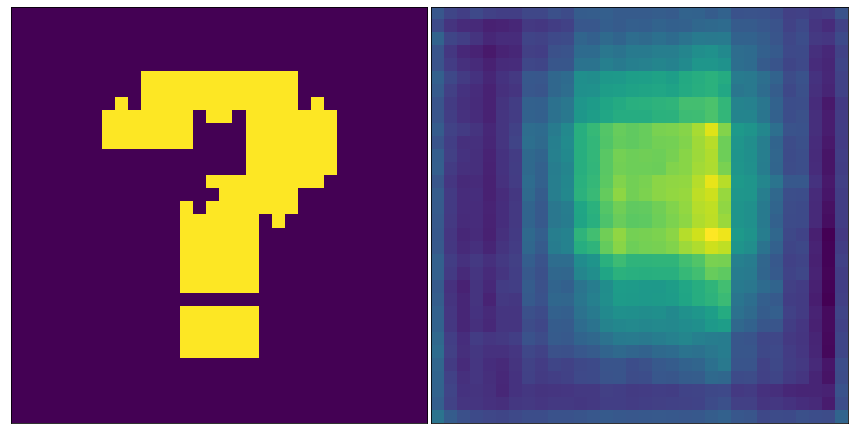

Epoch: 1, mask likelihood: 0.69173264503479, KL: 2.714, recon likelihood: 454.5426330566406
Epoch: 2, mask likelihood: 0.6894711852073669, KL: 2.851, recon likelihood: 310.26251220703125
Epoch: 3, mask likelihood: 0.6869662404060364, KL: 2.81, recon likelihood: 228.17257690429688
Epoch: 4, mask likelihood: 0.6836047172546387, KL: 3.62, recon likelihood: 187.2763671875
Epoch: 5, mask likelihood: 0.6793304085731506, KL: 4.723, recon likelihood: 166.7582244873047
Epoch: 6, mask likelihood: 0.6750407218933105, KL: 6.879, recon likelihood: 148.29470825195312
Epoch: 7, mask likelihood: 0.6700634360313416, KL: 8.743, recon likelihood: 130.64584350585938
Epoch: 8, mask likelihood: 0.6640151143074036, KL: 9.116, recon likelihood: 122.8203353881836
Epoch: 9, mask likelihood: 0.6575451493263245, KL: 8.799, recon likelihood: 117.42254638671875
Epoch: 10, mask likelihood: 0.6508997678756714, KL: 9.055, recon likelihood: 113.16535186767578
Best: 0.6508997678756714, 122.87147521972656, 0.86, epoch: 1

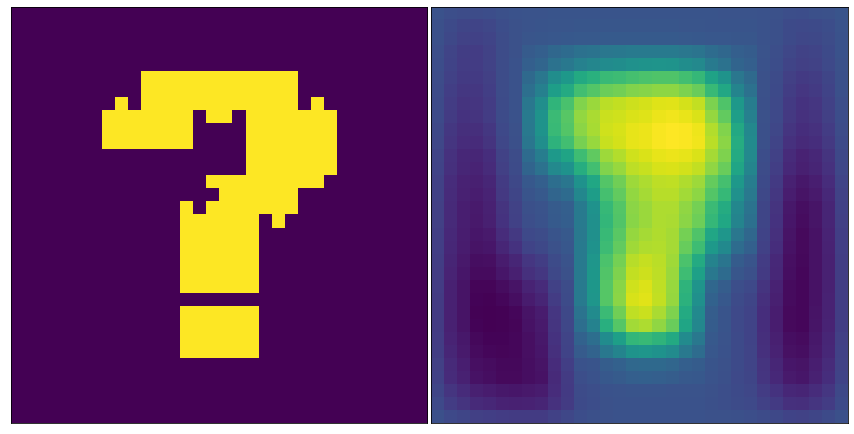

Epoch: 21, mask likelihood: 0.5411055684089661, KL: 11.543, recon likelihood: 91.22221374511719
Epoch: 22, mask likelihood: 0.5278298258781433, KL: 11.853, recon likelihood: 81.28831481933594
Epoch: 23, mask likelihood: 0.5152711272239685, KL: 11.674, recon likelihood: 77.95948791503906
Epoch: 24, mask likelihood: 0.5046749711036682, KL: 11.559, recon likelihood: 80.47466278076172
Epoch: 25, mask likelihood: 0.48977264761924744, KL: 11.862, recon likelihood: 79.70172882080078
Epoch: 26, mask likelihood: 0.47715774178504944, KL: 12.406, recon likelihood: 72.3209228515625
Epoch: 27, mask likelihood: 0.4651707410812378, KL: 12.664, recon likelihood: 70.03984069824219
Epoch: 28, mask likelihood: 0.45272842049598694, KL: 12.498, recon likelihood: 70.72050476074219
Epoch: 29, mask likelihood: 0.43796202540397644, KL: 12.124, recon likelihood: 75.1675796508789
Epoch: 30, mask likelihood: 0.4290296733379364, KL: 12.377, recon likelihood: 67.14250183105469
Best: 0.4290296733379364, 79.948822021

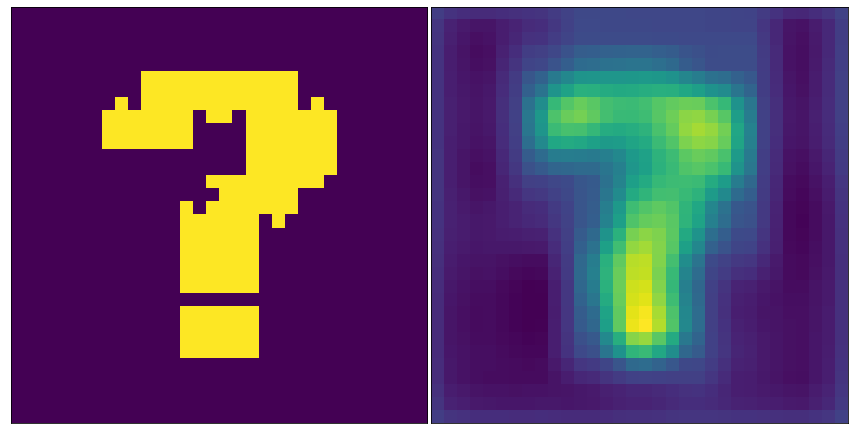

Epoch: 41, mask likelihood: 0.3207809031009674, KL: 12.614, recon likelihood: 66.12651062011719
Epoch: 42, mask likelihood: 0.31617915630340576, KL: 12.93, recon likelihood: 64.29130554199219
Epoch: 43, mask likelihood: 0.31074029207229614, KL: 13.093, recon likelihood: 57.88755416870117
Epoch: 44, mask likelihood: 0.2937018871307373, KL: 13.063, recon likelihood: 58.25590515136719
Epoch: 45, mask likelihood: 0.28695881366729736, KL: 12.859, recon likelihood: 63.26209259033203
Epoch: 46, mask likelihood: 0.27817800641059875, KL: 12.821, recon likelihood: 64.63209533691406
Epoch: 47, mask likelihood: 0.2673127055168152, KL: 12.914, recon likelihood: 54.44392395019531
Epoch: 48, mask likelihood: 0.26608937978744507, KL: 12.954, recon likelihood: 55.50548553466797
Epoch: 49, mask likelihood: 0.2734562158584595, KL: 13.078, recon likelihood: 57.9069709777832
Epoch: 50, mask likelihood: 0.24962909519672394, KL: 13.133, recon likelihood: 58.545169830322266
Best: 0.24962909519672394, 71.92827

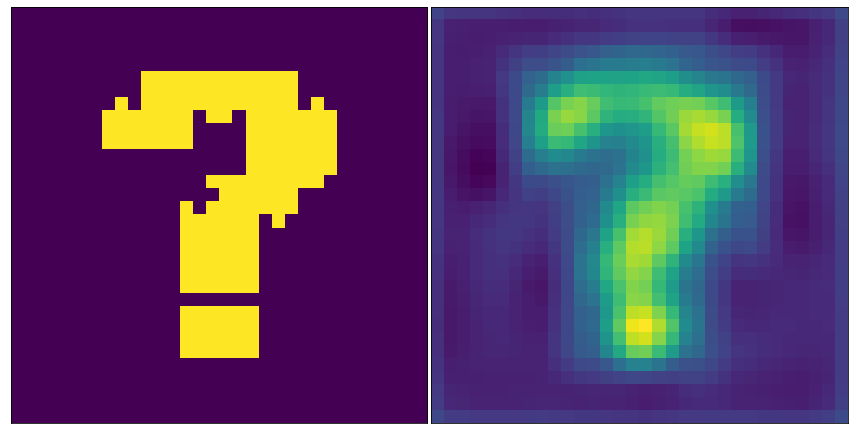

Epoch: 61, mask likelihood: 0.202435702085495, KL: 13.08, recon likelihood: 52.74375915527344
Epoch: 62, mask likelihood: 0.19017481803894043, KL: 13.174, recon likelihood: 55.771873474121094
Epoch: 63, mask likelihood: 0.19914783537387848, KL: 13.115, recon likelihood: 52.408729553222656
Epoch: 64, mask likelihood: 0.19358931481838226, KL: 13.081, recon likelihood: 51.82990264892578
Epoch: 65, mask likelihood: 0.19425535202026367, KL: 13.122, recon likelihood: 56.05500030517578
Epoch: 66, mask likelihood: 0.19748438894748688, KL: 13.173, recon likelihood: 52.07257843017578
Epoch: 67, mask likelihood: 0.1795492172241211, KL: 13.006, recon likelihood: 50.345027923583984
Epoch: 68, mask likelihood: 0.19062606990337372, KL: 13.13, recon likelihood: 56.30731201171875
Epoch: 69, mask likelihood: 0.1848926842212677, KL: 12.995, recon likelihood: 51.97067642211914
Epoch: 70, mask likelihood: 0.17129524052143097, KL: 13.002, recon likelihood: 50.23957824707031
Best: 0.17129524052143097, 63.412

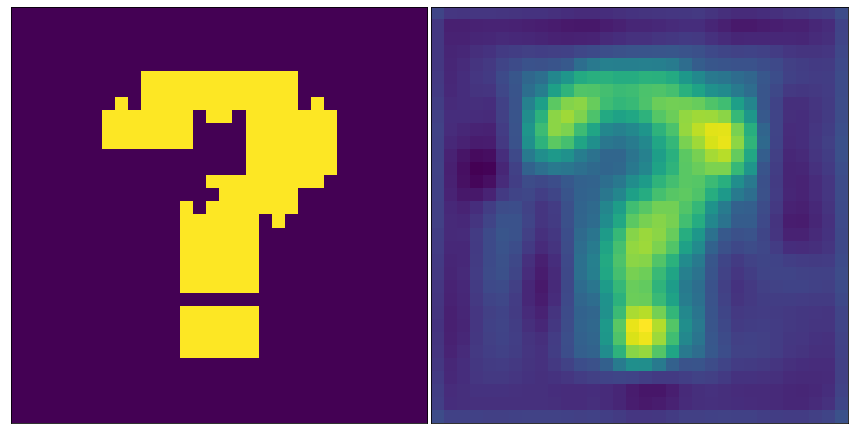

Epoch: 81, mask likelihood: 0.16803723573684692, KL: 13.295, recon likelihood: 49.61301803588867
Epoch: 82, mask likelihood: 0.15492261946201324, KL: 13.031, recon likelihood: 52.17629623413086
Epoch: 83, mask likelihood: 0.1576055884361267, KL: 12.938, recon likelihood: 49.106170654296875
Epoch: 84, mask likelihood: 0.15837571024894714, KL: 13.004, recon likelihood: 52.06745910644531
Epoch: 85, mask likelihood: 0.15394112467765808, KL: 13.362, recon likelihood: 48.59260940551758
Epoch: 86, mask likelihood: 0.1552433967590332, KL: 13.45, recon likelihood: 52.61143112182617
Epoch: 87, mask likelihood: 0.15846891701221466, KL: 13.468, recon likelihood: 48.765296936035156
Epoch: 88, mask likelihood: 0.16042356193065643, KL: 13.306, recon likelihood: 47.81035232543945
Epoch: 89, mask likelihood: 0.16360656917095184, KL: 13.09, recon likelihood: 48.28095245361328
Epoch: 90, mask likelihood: 0.16714201867580414, KL: 13.398, recon likelihood: 52.17940139770508
Best: 0.15394112467765808, 62.10

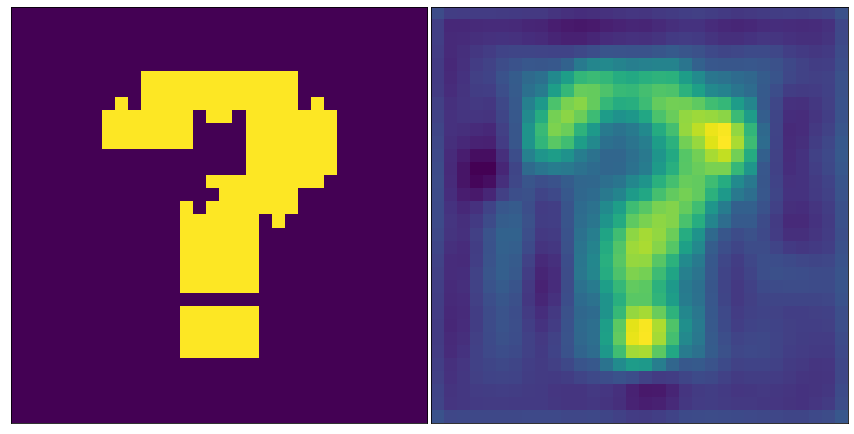

Epoch: 101, mask likelihood: 0.14910772442817688, KL: 13.206, recon likelihood: 50.45639419555664
Epoch: 102, mask likelihood: 0.151067852973938, KL: 12.993, recon likelihood: 54.00534439086914
Epoch: 103, mask likelihood: 0.16541257500648499, KL: 12.95, recon likelihood: 48.2836799621582
Epoch: 104, mask likelihood: 0.15738113224506378, KL: 12.989, recon likelihood: 49.28780746459961
Epoch: 105, mask likelihood: 0.14829133450984955, KL: 13.412, recon likelihood: 49.02154541015625
Epoch: 106, mask likelihood: 0.15862856805324554, KL: 13.524, recon likelihood: 49.8229866027832
Epoch: 107, mask likelihood: 0.14227275550365448, KL: 13.6, recon likelihood: 46.295310974121094
Epoch: 108, mask likelihood: 0.1552969068288803, KL: 13.478, recon likelihood: 48.11766815185547
Epoch: 109, mask likelihood: 0.1704970896244049, KL: 13.267, recon likelihood: 45.39540100097656
Epoch: 110, mask likelihood: 0.14461649954319, KL: 13.185, recon likelihood: 46.175086975097656
Best: 0.1396394520998001, 62.5

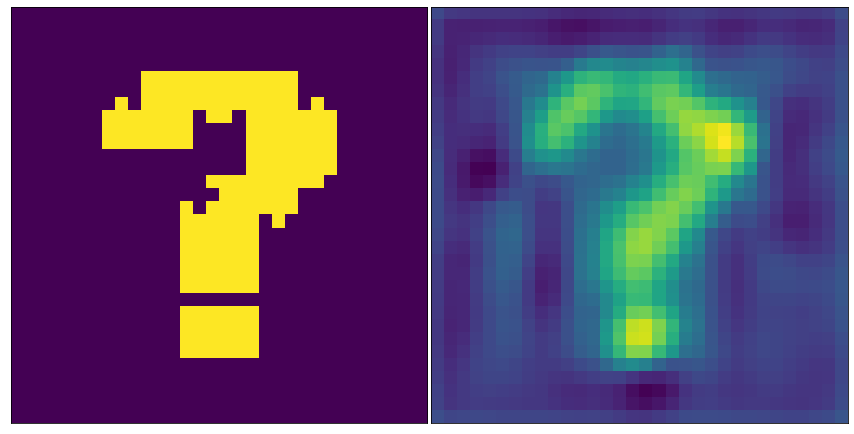

Epoch: 121, mask likelihood: 0.12872321903705597, KL: 13.369, recon likelihood: 47.01973342895508
Epoch: 122, mask likelihood: 0.1539854258298874, KL: 13.502, recon likelihood: 46.815956115722656
Epoch: 123, mask likelihood: 0.1523691564798355, KL: 13.533, recon likelihood: 45.48868179321289
Epoch: 124, mask likelihood: 0.15699517726898193, KL: 13.406, recon likelihood: 45.7131233215332
Epoch: 125, mask likelihood: 0.17333075404167175, KL: 13.668, recon likelihood: 46.61655807495117
Epoch: 126, mask likelihood: 0.16530506312847137, KL: 13.572, recon likelihood: 45.4352912902832
Epoch: 127, mask likelihood: 0.14312423765659332, KL: 13.386, recon likelihood: 50.73060989379883
Epoch: 128, mask likelihood: 0.15302735567092896, KL: 13.196, recon likelihood: 45.889041900634766
Epoch: 129, mask likelihood: 0.15178368985652924, KL: 12.957, recon likelihood: 45.965492248535156
Epoch: 130, mask likelihood: 0.15342959761619568, KL: 13.346, recon likelihood: 48.03339767456055
Best: 0.1287232190370

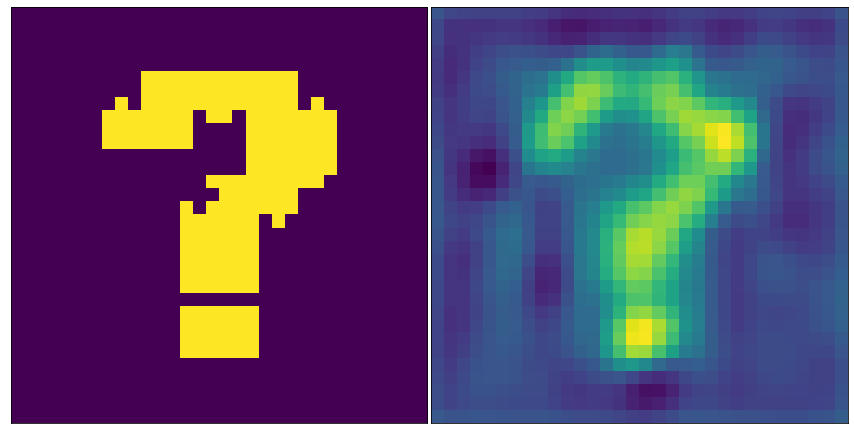

Epoch: 141, mask likelihood: 0.1748339831829071, KL: 13.416, recon likelihood: 42.33430099487305
Epoch: 142, mask likelihood: 0.15039823949337006, KL: 13.67, recon likelihood: 43.82861328125
Epoch: 143, mask likelihood: 0.15787334740161896, KL: 13.667, recon likelihood: 42.782470703125
Epoch: 144, mask likelihood: 0.16059237718582153, KL: 13.525, recon likelihood: 46.11491012573242
Epoch: 145, mask likelihood: 0.15529204905033112, KL: 13.131, recon likelihood: 43.75605392456055
Epoch: 146, mask likelihood: 0.14156703650951385, KL: 13.036, recon likelihood: 44.565555572509766
Epoch: 147, mask likelihood: 0.15715469419956207, KL: 13.224, recon likelihood: 49.75961685180664
Epoch: 148, mask likelihood: 0.1661377251148224, KL: 13.409, recon likelihood: 42.43047332763672
Epoch: 149, mask likelihood: 0.16729682683944702, KL: 13.69, recon likelihood: 44.35191345214844
Epoch: 150, mask likelihood: 0.15362772345542908, KL: 13.706, recon likelihood: 45.82917404174805
Best: 0.12872321903705597, 6

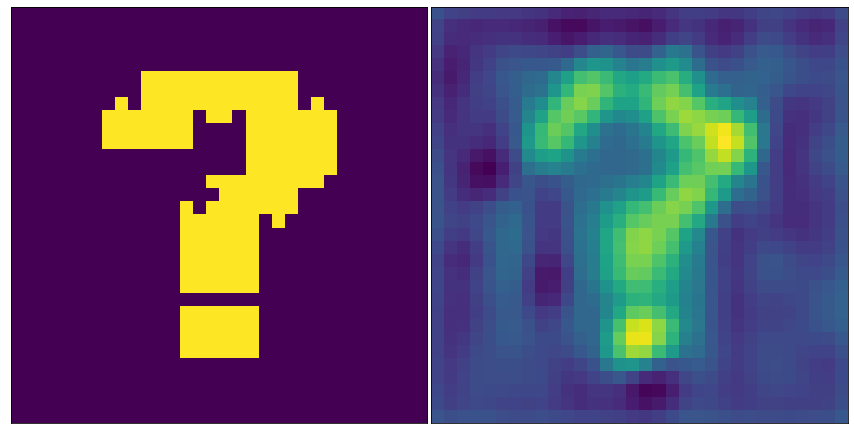

Epoch: 161, mask likelihood: 0.13835011422634125, KL: 13.521, recon likelihood: 41.92876052856445
Epoch: 162, mask likelihood: 0.14650858938694, KL: 13.509, recon likelihood: 45.78706359863281
Epoch: 163, mask likelihood: 0.17311200499534607, KL: 13.535, recon likelihood: 44.7289924621582
Epoch: 164, mask likelihood: 0.17816117405891418, KL: 13.487, recon likelihood: 42.177146911621094
Epoch: 165, mask likelihood: 0.1377933770418167, KL: 13.275, recon likelihood: 46.83948516845703
Epoch: 166, mask likelihood: 0.15209071338176727, KL: 13.227, recon likelihood: 45.63532257080078
Epoch: 167, mask likelihood: 0.1817326694726944, KL: 13.405, recon likelihood: 41.14200973510742
Epoch: 168, mask likelihood: 0.15926438570022583, KL: 13.65, recon likelihood: 41.85141372680664
Epoch: 169, mask likelihood: 0.1444176286458969, KL: 13.543, recon likelihood: 47.35774230957031
Epoch: 170, mask likelihood: 0.1436435878276825, KL: 13.547, recon likelihood: 42.72079849243164
Best: 0.1279415339231491, 58

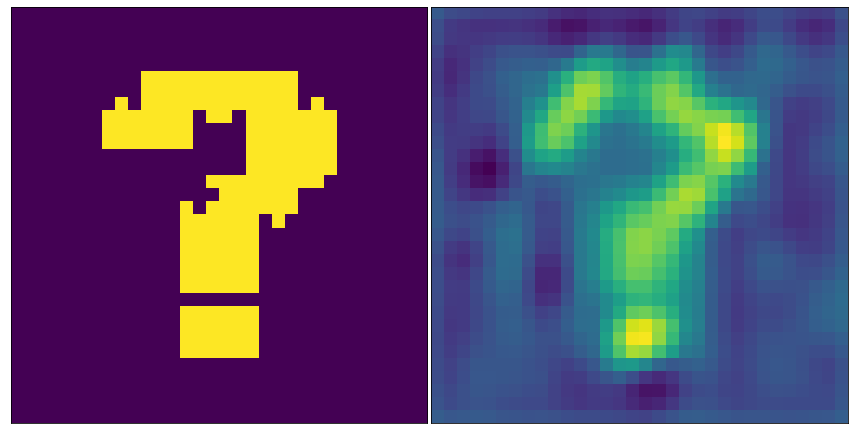

Epoch: 181, mask likelihood: 0.14262263476848602, KL: 13.558, recon likelihood: 41.39099884033203
Epoch: 182, mask likelihood: 0.177824467420578, KL: 13.543, recon likelihood: 44.73058319091797
Epoch: 183, mask likelihood: 0.1647849828004837, KL: 13.66, recon likelihood: 44.85114288330078
Epoch: 184, mask likelihood: 0.14852243661880493, KL: 13.503, recon likelihood: 40.261817932128906
Epoch: 185, mask likelihood: 0.21914729475975037, KL: 13.522, recon likelihood: 43.69148254394531
Epoch: 186, mask likelihood: 0.19323240220546722, KL: 13.493, recon likelihood: 42.12802505493164
Epoch: 187, mask likelihood: 0.15410715341567993, KL: 13.487, recon likelihood: 44.96535873413086
Epoch: 188, mask likelihood: 0.20370478928089142, KL: 13.614, recon likelihood: 39.977439880371094
Epoch: 189, mask likelihood: 0.16643445193767548, KL: 13.706, recon likelihood: 39.94871139526367
Epoch: 190, mask likelihood: 0.1430220752954483, KL: 13.766, recon likelihood: 42.65079879760742
Best: 0.127941533923149

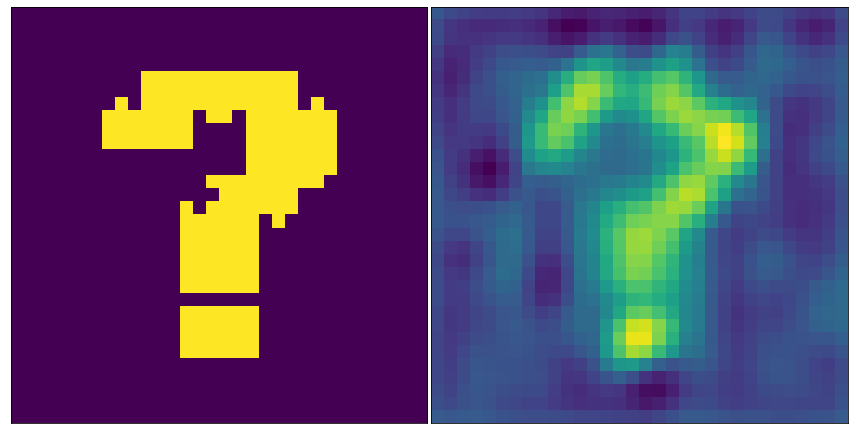

Epoch: 201, mask likelihood: 0.16736255586147308, KL: 13.684, recon likelihood: 42.22968673706055
Epoch: 202, mask likelihood: 0.17157290875911713, KL: 13.582, recon likelihood: 42.32666778564453
Epoch: 203, mask likelihood: 0.1877419650554657, KL: 13.496, recon likelihood: 43.31705093383789
Epoch: 204, mask likelihood: 0.1795268952846527, KL: 13.707, recon likelihood: 38.680091857910156
Epoch: 205, mask likelihood: 0.1668504923582077, KL: 13.526, recon likelihood: 43.041893005371094
Epoch: 206, mask likelihood: 0.1752437949180603, KL: 13.477, recon likelihood: 41.748104095458984
Epoch: 207, mask likelihood: 0.19451923668384552, KL: 13.646, recon likelihood: 40.71709060668945
Epoch: 208, mask likelihood: 0.19774293899536133, KL: 13.751, recon likelihood: 42.51620101928711
Epoch: 209, mask likelihood: 0.18941526114940643, KL: 13.72, recon likelihood: 43.08316421508789
Epoch: 210, mask likelihood: 0.1856149286031723, KL: 13.494, recon likelihood: 43.547386169433594
Best: 0.12772542238235

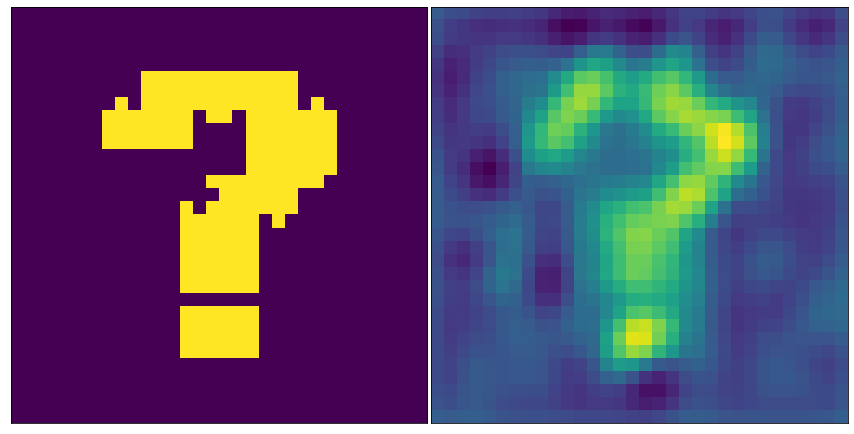

Epoch: 221, mask likelihood: 0.1886628121137619, KL: 13.513, recon likelihood: 43.242469787597656
Epoch: 222, mask likelihood: 0.19111183285713196, KL: 13.24, recon likelihood: 41.50917434692383
Epoch: 223, mask likelihood: 0.18899528682231903, KL: 13.454, recon likelihood: 38.49443435668945
Epoch: 224, mask likelihood: 0.19773077964782715, KL: 13.75, recon likelihood: 40.11695098876953
Epoch: 225, mask likelihood: 0.22165000438690186, KL: 13.595, recon likelihood: 39.459144592285156
Epoch: 226, mask likelihood: 0.18048961460590363, KL: 13.632, recon likelihood: 38.95830154418945
Epoch: 227, mask likelihood: 0.17300723493099213, KL: 13.669, recon likelihood: 38.62497329711914
Epoch: 228, mask likelihood: 0.21354179084300995, KL: 13.721, recon likelihood: 37.99831771850586
Epoch: 229, mask likelihood: 0.19468392431735992, KL: 13.774, recon likelihood: 40.40503692626953
Epoch: 230, mask likelihood: 0.1979880928993225, KL: 13.682, recon likelihood: 37.33589172363281
Best: 0.12772542238235

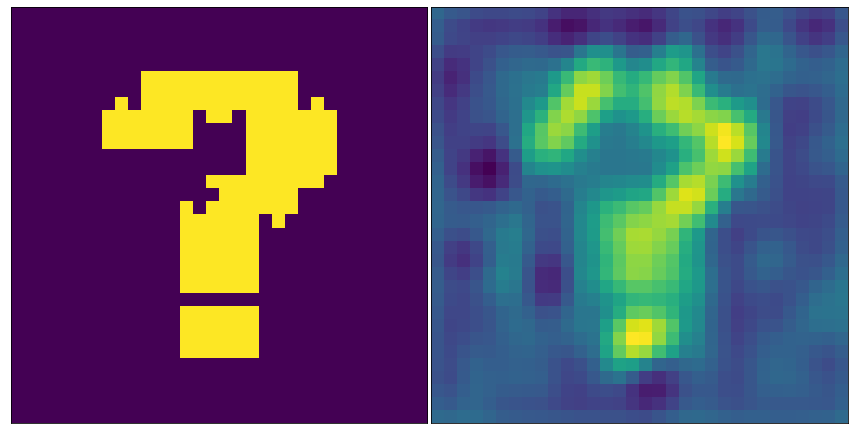

Epoch: 241, mask likelihood: 0.20000314712524414, KL: 13.561, recon likelihood: 41.48236083984375
Epoch: 242, mask likelihood: 0.22622811794281006, KL: 13.366, recon likelihood: 37.488834381103516
Epoch: 243, mask likelihood: 0.20830081403255463, KL: 13.58, recon likelihood: 41.847869873046875
Epoch: 244, mask likelihood: 0.21004526317119598, KL: 13.785, recon likelihood: 38.68156051635742
Epoch: 245, mask likelihood: 0.21906539797782898, KL: 13.826, recon likelihood: 36.91593933105469
Epoch: 246, mask likelihood: 0.20919577777385712, KL: 13.911, recon likelihood: 39.90190887451172
Epoch: 247, mask likelihood: 0.1927378922700882, KL: 13.76, recon likelihood: 42.35951614379883
Epoch: 248, mask likelihood: 0.20401963591575623, KL: 13.484, recon likelihood: 39.99517822265625
Epoch: 249, mask likelihood: 0.2134401500225067, KL: 13.713, recon likelihood: 39.836708068847656


In [8]:
import torch as tc

best_loss = 1e30
best_acc = 0
best_lk = 1e30
global_step = 0

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    model.zero_grad()
    train_acc = 0
    t_epoch_loss = 0

    # The trackers for the mean and scale of the inference map
    vae_mask = np.zeros((INPUT_SIZE, INPUT_SIZE))
    vae_scale = np.zeros((INPUT_SIZE, INPUT_SIZE))

    for (x, y) in train_loader:
        optimizer.zero_grad()

        x = x.type(Tensor).to(device)
        y = y.type(Tensor).to(device)

        ret_dict = model(x, y)

        loss = ret_dict['loss'].mean()
        t_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        vae_mask += np.squeeze(ret_dict['mean_mask'].cpu().data.numpy())
        vae_scale += np.squeeze(ret_dict['mask_scale'].cpu().data.numpy())
        train_acc += 1
        global_step += 1
        
    training_losses.append(t_epoch_loss / train_acc)

    vae_mask = vae_mask / train_acc
    val_mask = tc.from_numpy(vae_mask).type(Tensor).to(device).view(1, 1,
                                                                    INPUT_SIZE,
                                                                    INPUT_SIZE)
    vae_scale = vae_scale / train_acc
    val_scale = tc.from_numpy(vae_scale).type(Tensor).to(device).view(1, 1,
                                                                    INPUT_SIZE,
                                                                    INPUT_SIZE)

    val_acc = 0
    accuracy_acc = 0
    loss_acc = 0
    likelihood_acc = 0
    kld_acc = 0
    recon_acc = 0
    with torch.no_grad():
        for (x, y) in val_loader:
            x = x.type(Tensor).to(device)
            y = y.type(Tensor).to(device)

            ret_dict = model(x, y,
                             provided_mask=val_mask,
                             provided_scale=val_scale,
                             val=True)

            loss_acc += ret_dict['loss'].mean().item()
            val_acc += 1
            likelihood_acc += ret_dict['mask_ll'].item()
            accuracy_acc += ret_dict['acc'].item()
            kld_acc += ret_dict['kl'].item()
            recon_acc += ret_dict['recon_ll'].item()

    loss = loss_acc / val_acc
    validation_losses.append(loss)
    lk = likelihood_acc / val_acc
    acc = round(accuracy_acc / val_acc, 4)
    kl = round(kld_acc / val_acc, 3)
    rec = recon_acc / val_acc

    print(f'Epoch: {epoch}, mask likelihood: {lk}, KL: {kl}, recon likelihood: {rec}')
    
    if lk < best_lk:
        best_loss = loss
        best_lk = lk
        best_acc = acc
        best_recon = recon_acc
        best_epoch = epoch
        torch.save(model, f"vae.pth")
        np.save(f'vae_mask.npy', vae_mask)
        np.save(f'vae_scale.npy', vae_scale)
    
    if epoch % 10 == 0:
        print(f'Best: {best_lk}, {best_loss}, {best_acc}, epoch: {best_epoch}')
        
    # VIZUALISE AS THE TRAINING GOES ON
    if epoch % 20 == 0:

        subtitle_fontsize = 30

        imgs = x.cpu().data.numpy()

        question_mark = ret_dict['mean_mask'].cpu().data.numpy()

        b, c, h, w = imgs.shape
        imgs = np.reshape(imgs, [-1, h, w])
        question_mark = np.reshape(question_mark, [h, w])
        mask_scale = np.reshape(vae_mask, [1, h, w])
        
        fig = plt.figure(figsize=(15., 15.))
        grid = ImageGrid(fig, 111, 
                         nrows_ncols=(1, 2),
                         axes_pad=0.05,
                         share_all=True
                         )

        grid[0].get_yaxis().set_ticks([])
        grid[0].get_xaxis().set_ticks([])

        # The substrate
        grid[0].imshow(substrate)
        
        # The recovered substrate
        grid[1].imshow(question_mark)
        
        plt.show()

In [26]:
model = torch.load("vae.pth")
model.eval()
vae_mask = np.load('vae_mask.npy')

best_threshold = 0
best_loss = 1e30

threshold_range = np.linspace(0.85, 0.99, num=30)
for thresh in threshold_range:
    with torch.no_grad():
        counter = 0
        loss = 0
        for (x, y) in cal_loader:
            x = x.type(Tensor).to(device)
            y = y.type(Tensor).to(device)
            ret_dict = model(x, y,
                             calibrate=True,
                             t=float(thresh))

            loss += ret_dict['loss']
            counter += 1
        loss = loss / counter
        print(f'{thresh}, {loss}')
        if loss < best_loss:
            best_loss = loss
            best_threshold = thresh
    
# FIND THE BEST THRESHOLD
t = np.quantile(vae_mask, best_threshold)

0.85, 49.87931823730469
0.8548275862068966, 50.466522216796875
0.8596551724137931, 50.179046630859375
0.8644827586206897, 49.190460205078125
0.8693103448275862, 49.245296478271484
0.8741379310344828, 50.10844421386719
0.8789655172413793, 51.147396087646484
0.8837931034482759, 49.61522674560547
0.8886206896551724, 50.610504150390625
0.893448275862069, 50.319454193115234
0.8982758620689655, 49.101951599121094
0.9031034482758621, 50.06876754760742
0.9079310344827586, 50.10262680053711
0.9127586206896552, 49.271541595458984
0.9175862068965517, 49.32302474975586
0.9224137931034483, 49.963600158691406
0.9272413793103448, 49.997989654541016
0.9320689655172414, 49.51327896118164
0.9368965517241379, 49.93131637573242
0.9417241379310345, 49.76252365112305
0.946551724137931, 50.81172180175781
0.9513793103448276, 50.14139938354492
0.9562068965517241, 50.10524368286133
0.9610344827586207, 49.805049896240234
0.9658620689655172, 50.06552505493164
0.9706896551724138, 50.08280944824219
0.97551724137931

In [13]:
# RUN SVR-LSM APPROXIMATION FOR DEBUGGING PURPOSES
from sklearn import svm

# We're doing binary classification
continuous = False

svm_data = np.reshape(train_data, [train_data.shape[0], train_data.shape[2]**2])

svr_labels = train_labels
if continuous:
    svr_labels = (train_labels - train_labels.mean())
    svr_labels = svr_labels / svr_labels.std()
svm_data = svm_data / (np.linalg.norm(svm_data, axis=-1, keepdims=True) + 1e-5)

if continuous:
    svm = svm.SVR(kernel='rbf', C=0.8)
else:
    svm = svm.SVC(kernel='rbf')
svm.fit(svm_data, svr_labels)

alphas = svm.dual_coef_

backprojection = alphas * np.transpose(svm.support_vectors_)
backprojection = np.sum(backprojection, axis=1)
svm_preds = np.reshape(backprojection, [train_data.shape[2], train_data.shape[2]])
svm_preds.shape

(32, 32)

In [14]:
# RUN VLSM APPROXIMATION FOR DEBUGGING PURPOSES

idxs_p = np.where(train_labels > 0)
idxs_n = np.where(train_labels == 0)
img_size = 32

fisher_preds = np.zeros((img_size, img_size))
for i in range(img_size):
    for j in range(img_size):
        index_vox = train_data[:, 0, i, j]

        table = np.zeros((2, 2))
        table[0, 0] = np.sum(index_vox[idxs_n] == 0)
        table[0, 1] = np.sum(index_vox[idxs_n] > 0)
        table[1, 0] = np.sum(index_vox[idxs_p] == 0)
        table[1, 1] = np.sum(index_vox[idxs_p] > 0)

        p_value = scipy.stats.fisher_exact(table, 'greater')[-1]
        fisher_preds[i, j] = p_value

fisher_preds = - np.log(fisher_preds)
univar_preds = fisher_preds

In [15]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [27]:
best_threshold

0.8982758620689655

In [28]:
from monai.metrics import compute_hausdorff_distance, compute_average_surface_distance

'''
THIS IS JUST FOR DEBUGGING PURPOSES
FOR PROPER EVALUATION YOU'LL HAVE TO GET P-VALUES FOR VLSM AND SVR-LSM 
AND THEN USE FWER/FDR
'''

results = {'VDVAE-LDM': vae_mask, 'VLSM': univar_preds, 'SVR-LSM': svm_preds}

keys = ['VDVAE-LDM', 'VLSM', 'SVR-LSM']
thresholds = {}
for k in keys:
    thresholds[k] = {'dice': [0, 0], 'hausdorff': [1e10, 0], 'asd': [1e10, 0],
                    }

for k in results:
    results[k] = results[k] - results[k].min()
    results[k] = results[k] / (results[k].max())

# threshold_range = np.linspace(0.8, 0.98, num=20)
threshold_range = [0.9]

for thresh in threshold_range:
    for k in thresholds:
        if k == 'VDVAE-LDM':
            t = np.quantile(results[k], best_threshold)
        else:
            t = np.quantile(results[k], thresh)
        bin_res = results[k] > t

        preds = np.expand_dims(np.expand_dims(results[k], axis=0), axis=0)
        bin_preds = np.expand_dims(np.expand_dims(bin_res, axis=0), axis=0)
        monai_gt = np.expand_dims(np.expand_dims(substrate, axis=0), axis=0)
        
        dice_s = dice(bin_res, substrate)
            
        if dice_s > thresholds[k]['dice'][0]:
            thresholds[k]['dice'][0] = round(dice_s, 2)
            if k == 'VDVAE-LDM':
                thresholds[k]['dice'][1] = best_threshold
            else:
                thresholds[k]['dice'][1] = thresh
            
            haus = compute_hausdorff_distance(bin_preds, monai_gt).numpy()[0][0]
            asd = compute_average_surface_distance(bin_preds, monai_gt,
                                                   symmetric=False).numpy()[0][0]
            
            thresholds[k]['hausdorff'][0] = round(haus, 2)
            thresholds[k]['hausdorff'][1] = thresh
            
            thresholds[k]['asd'][0] = round(asd, 2)
            thresholds[k]['asd'][1] = thresh
            
            
thresholds

{'VDVAE-LDM': {'dice': [0.72, 0.8982758620689655],
  'hausdorff': [2.24, 0.9],
  'asd': [0.7, 0.9]},
 'VLSM': {'dice': [0.59, 0.9], 'hausdorff': [3.61, 0.9], 'asd': [0.81, 0.9]},
 'SVR-LSM': {'dice': [0.68, 0.9],
  'hausdorff': [2.24, 0.9],
  'asd': [0.75, 0.9]}}

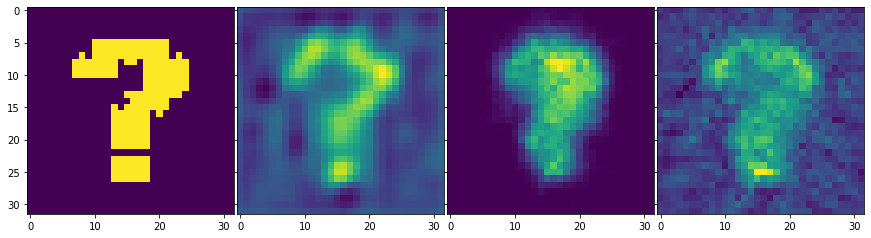

In [29]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(1, 4),
                 axes_pad=0.05,
                 share_all=True
                 )

grid[0].imshow(substrate)
grid[1].imshow(vae_mask)
grid[2].imshow(univar_preds)
grid[3].imshow(svm_preds)